<h3>   Target:   </h3>
<h6>Add regularization  </h6> 
<h6>Add GAP   </h6>
<h6>Increase the capacity  </h6>
<h3>    Results:  </h3>
<h6>Parameters: 11,994  </h6>
<h6>Best Train Accuracy: 99.27  </h6>  
<h6>Best Test Accuracy:  99.06 (18th Epoch), 99.12 (20th Epoch)</h6>  
<h3>    Analysis: </h3>
<h6>Regularization working.   </h6>
<h6>Fix DropOut, and check needed to add in all the layers  </h6>
<h6>We can also increase the capacity of the model by adding a layer after GAP!   </h6>     

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# CODE BLOCK 1
### import neccessary packages for training the mnist model

In [2]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

%matplotlib inline
import matplotlib.pyplot as plt

from torchsummary import summary
from tqdm import tqdm
from torch.optim.lr_scheduler import StepLR

In [3]:
# import custom modules
%cd '/content/gdrive/MyDrive/ERA2/session7/'
import model

/content/gdrive/MyDrive/ERA2/session7


# Data Transformations

#### We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.

In [4]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [5]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

# Dataloader Arguments & Test/Train Dataloaders


In [6]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


# Data Statistics

It is important to know your data very well. Let's check some of the statistics around our data and how it actually looks like

/usr/local/lib/python3.10/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")


[Train]
 - Numpy Shape: (60000, 28, 28)
 - Tensor Shape: torch.Size([60000, 28, 28])
 - min: tensor(-0.4242)
 - max: tensor(2.8215)
 - mean: tensor(-0.0001)
 - std: tensor(1.0000)
 - var: tensor(1.0001)
torch.Size([128, 1, 28, 28])
torch.Size([128])


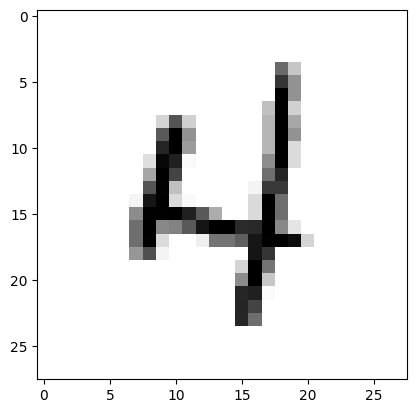

In [7]:
# We'd need to convert it into Numpy! Remember above we have converted it into tensors already
train_data = train.train_data
train_data = train.transform(train_data.numpy())

print('[Train]')
print(' - Numpy Shape:', train.train_data.cpu().numpy().shape)
print(' - Tensor Shape:', train.train_data.size())
print(' - min:', torch.min(train_data))
print(' - max:', torch.max(train_data))
print(' - mean:', torch.mean(train_data))
print(' - std:', torch.std(train_data))
print(' - var:', torch.var(train_data))

dataiter = iter(train_loader)
images, labels = next(dataiter)

print(images.shape)
print(labels.shape)

# Let's visualize some of the images
%matplotlib inline
import matplotlib.pyplot as plt

plt.imshow(images[0].numpy().squeeze(), cmap='gray_r')

## MORE

It is important that we view as many images as possible. This is required to get some idea on image augmentation later on

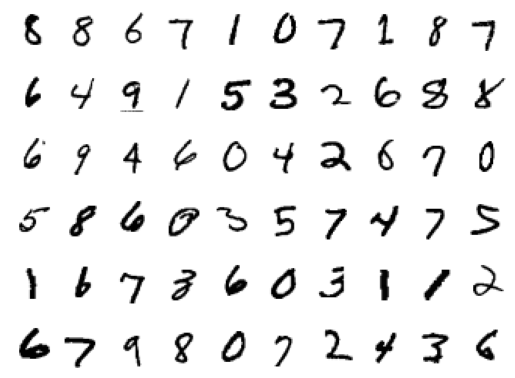

In [8]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray_r')

# Load the Model_2

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model_2 = model.Model_2().to(device)
summary(model_2, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]              90
       BatchNorm2d-2           [-1, 10, 26, 26]              20
              ReLU-3           [-1, 10, 26, 26]               0
            Conv2d-4           [-1, 10, 24, 24]             900
       BatchNorm2d-5           [-1, 10, 24, 24]              20
              ReLU-6           [-1, 10, 24, 24]               0
            Conv2d-7           [-1, 20, 22, 22]           1,800
       BatchNorm2d-8           [-1, 20, 22, 22]              40
              ReLU-9           [-1, 20, 22, 22]               0
          Dropout-10           [-1, 20, 22, 22]               0
        MaxPool2d-11           [-1, 20, 11, 11]               0
           Conv2d-12           [-1, 10, 11, 11]             200
      BatchNorm2d-13           [-1, 10, 11, 11]              20
             ReLU-14           [-1

In [10]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [11]:
optimizer = optim.SGD(model_2.parameters(), lr=0.01, momentum=0.9)
EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model_2, device, train_loader, optimizer, epoch)
    test(model_2, device, test_loader)

EPOCH: 0


Loss=0.123329758644104 Batch_id=468 Accuracy=83.88: 100%|██████████| 469/469 [00:17<00:00, 26.88it/s]



Test set: Average loss: 0.1446, Accuracy: 9625/10000 (96.25%)

EPOCH: 1


Loss=0.054714400321245193 Batch_id=468 Accuracy=97.41: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.1040, Accuracy: 9717/10000 (97.17%)

EPOCH: 2


Loss=0.048974741250276566 Batch_id=468 Accuracy=98.16: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0632, Accuracy: 9818/10000 (98.18%)

EPOCH: 3


Loss=0.013662118464708328 Batch_id=468 Accuracy=98.35: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0706, Accuracy: 9796/10000 (97.96%)

EPOCH: 4


Loss=0.0432538241147995 Batch_id=468 Accuracy=98.62: 100%|██████████| 469/469 [00:18<00:00, 25.94it/s]



Test set: Average loss: 0.0575, Accuracy: 9824/10000 (98.24%)

EPOCH: 5


Loss=0.05717644467949867 Batch_id=468 Accuracy=98.72: 100%|██████████| 469/469 [00:17<00:00, 27.51it/s]



Test set: Average loss: 0.0567, Accuracy: 9829/10000 (98.29%)

EPOCH: 6


Loss=0.010387063957750797 Batch_id=468 Accuracy=98.78: 100%|██████████| 469/469 [00:17<00:00, 27.27it/s]



Test set: Average loss: 0.0546, Accuracy: 9843/10000 (98.43%)

EPOCH: 7


Loss=0.029162177816033363 Batch_id=468 Accuracy=98.86: 100%|██████████| 469/469 [00:18<00:00, 25.82it/s]



Test set: Average loss: 0.0414, Accuracy: 9883/10000 (98.83%)

EPOCH: 8


Loss=0.04774455353617668 Batch_id=468 Accuracy=98.88: 100%|██████████| 469/469 [00:17<00:00, 27.12it/s]



Test set: Average loss: 0.0518, Accuracy: 9836/10000 (98.36%)

EPOCH: 9


Loss=0.07391591370105743 Batch_id=468 Accuracy=98.96: 100%|██████████| 469/469 [00:17<00:00, 26.70it/s]



Test set: Average loss: 0.0380, Accuracy: 9890/10000 (98.90%)

EPOCH: 10


Loss=0.012447682209312916 Batch_id=468 Accuracy=99.02: 100%|██████████| 469/469 [00:17<00:00, 27.52it/s]



Test set: Average loss: 0.0387, Accuracy: 9880/10000 (98.80%)

EPOCH: 11


Loss=0.04514935612678528 Batch_id=468 Accuracy=99.10: 100%|██████████| 469/469 [00:21<00:00, 21.57it/s]



Test set: Average loss: 0.0367, Accuracy: 9884/10000 (98.84%)

EPOCH: 12


Loss=0.09205951541662216 Batch_id=468 Accuracy=99.11: 100%|██████████| 469/469 [00:21<00:00, 21.81it/s]



Test set: Average loss: 0.0377, Accuracy: 9900/10000 (99.00%)

EPOCH: 13


Loss=0.02525792457163334 Batch_id=468 Accuracy=99.14: 100%|██████████| 469/469 [00:18<00:00, 25.39it/s]



Test set: Average loss: 0.0352, Accuracy: 9899/10000 (98.99%)

EPOCH: 14


Loss=0.01519667636603117 Batch_id=468 Accuracy=99.16: 100%|██████████| 469/469 [00:17<00:00, 27.30it/s]



Test set: Average loss: 0.0387, Accuracy: 9886/10000 (98.86%)

EPOCH: 15


Loss=0.0063573080115020275 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:17<00:00, 27.39it/s]



Test set: Average loss: 0.0360, Accuracy: 9894/10000 (98.94%)

EPOCH: 16


Loss=0.0038785934448242188 Batch_id=468 Accuracy=99.22: 100%|██████████| 469/469 [00:17<00:00, 26.40it/s]



Test set: Average loss: 0.0374, Accuracy: 9889/10000 (98.89%)

EPOCH: 17


Loss=0.045201387256383896 Batch_id=468 Accuracy=99.27: 100%|██████████| 469/469 [00:16<00:00, 27.69it/s]



Test set: Average loss: 0.0308, Accuracy: 9906/10000 (99.06%)

EPOCH: 18


Loss=0.01946208067238331 Batch_id=468 Accuracy=99.23: 100%|██████████| 469/469 [00:18<00:00, 25.90it/s]



Test set: Average loss: 0.0349, Accuracy: 9890/10000 (98.90%)

EPOCH: 19


Loss=0.004218024667352438 Batch_id=468 Accuracy=99.25: 100%|██████████| 469/469 [00:17<00:00, 26.86it/s]



Test set: Average loss: 0.0297, Accuracy: 9912/10000 (99.12%)



Text(0.5, 1.0, 'Test Accuracy')

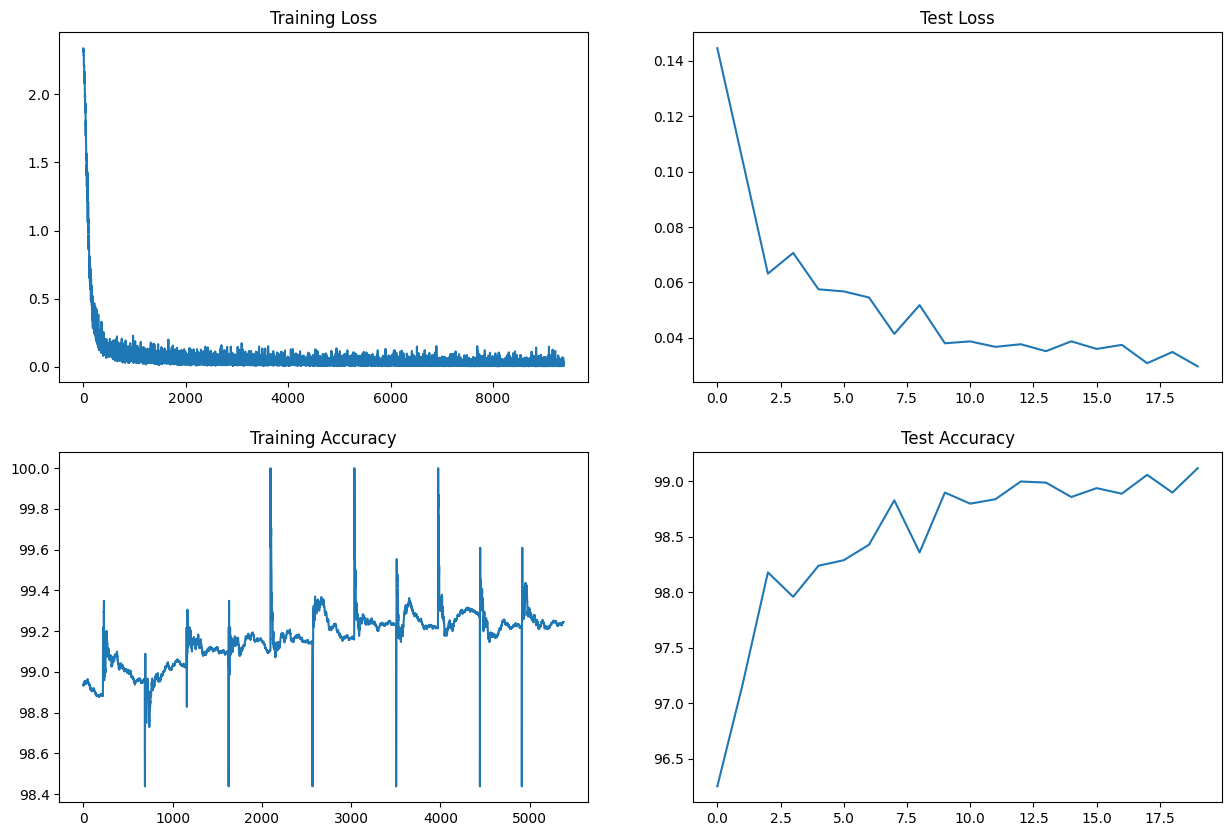

In [12]:
t = [t_items.item() for t_items in train_losses]

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")